In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import os
import requests

import pandas as pd
import random
import numpy as np

covid_path = os.path.join('/content','drive','My Drive','covid')


In [3]:
rilevazioni = pd.read_csv('/content/drive/My Drive/IT/Python/covid/rilevazioni.csv').set_index(['Regione','Citta'])
rilevazioni.iloc[:,15:]

23-03  24-03  25-03  ...  09-04  10-04  11-04
Regione   Citta                                 ...                     
LOMBARDIA BERGAMO           6471   6728   7072  ...  10043  10151  10258
          BRESCIA           5905   6298   6597  ...  10122  10369  10599
          COMO               581    635    706  ...   1605   1686   1825
          CREMONA           2925   3061   3156  ...   4489   4562   4658
          LECCO              934   1015   1076  ...   1805   1838   1860
...                          ...    ...    ...  ...    ...    ...    ...
CALABRIA  COSENZA             68     84     99  ...    275    289    291
          REGGIO CALABRIA     94     97    105  ...    250    256    260
          CATANZARO           46     49     51  ...    173    176    181
          VIBO VALENTIA       20     21     23  ...     61     65     68
          CROTONE             62     66     71  ...    113    113    113

[108 rows x 20 columns]

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
% matplotlib inline

def plot_annotate(df, title='', xdelta=0, ydelta=10, figsize=(17, 7)):
  
  ax = df.T.plot(figsize=figsize, title=title)
  ax.set_xticks(ticks=np.arange(0, len(df.columns), step=2))
  tick_label = list(df.columns)[::2]
  ax.set_xticklabels(tick_label)

  for k, v in zip(np.arange(len(df.columns)), df.T.iterrows()):
    for el in v[1]:
      ax.annotate(el, (k + xdelta, el + ydelta))
  return ax

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
sorted_by_infections = rilevazioni.loc[rilevazioni.sort_values(by=[rilevazioni.columns[-1]],ascending=False).index]

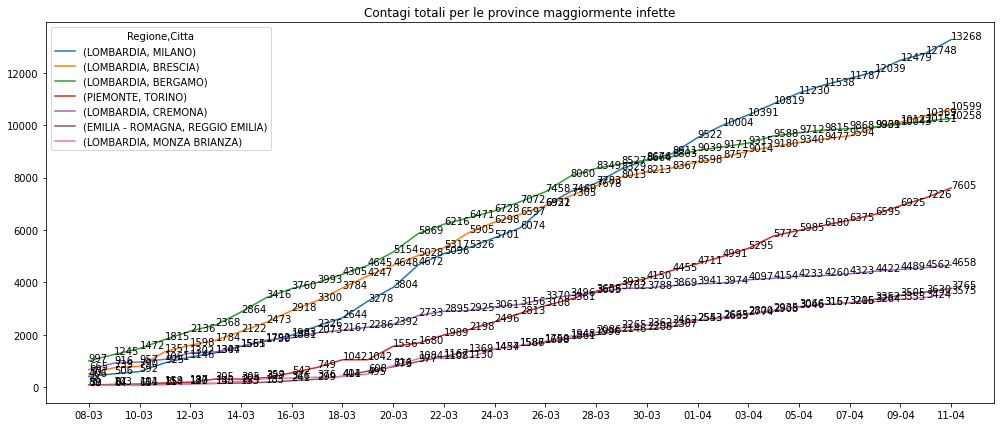

In [6]:
_ = plot_annotate(sorted_by_infections.head(7),'Contagi totali per le province maggiormente infette')

In [0]:
crescita = pd.DataFrame(index=sorted_by_infections.index)

In [0]:
for ieri, oggi in zip(sorted_by_infections.columns[:-1], sorted_by_infections.columns[1:]):
  crescita[oggi] = sorted_by_infections[oggi] - sorted_by_infections[ieri]

In [9]:
display(crescita.head(3))
sorted_by_infections.head(3)

09-03  10-03  11-03  12-03  ...  08-04  09-04  10-04  11-04
Regione   Citta                                ...                            
LOMBARDIA MILANO     100     86    333    221  ...    252    440    269    520
          BRESCIA    238     51    561    247  ...    315    213    247    230
          BERGAMO    248    227    343    321  ...     63    112    108    107

[3 rows x 34 columns]

08-03  09-03  10-03  11-03  ...  08-04  09-04  10-04  11-04
Regione   Citta                                ...                            
LOMBARDIA MILANO     406    506    592    925  ...  12039  12479  12748  13268
          BRESCIA    501    739    790   1351  ...   9909  10122  10369  10599
          BERGAMO    997   1245   1472   1815  ...   9931  10043  10151  10258

[3 rows x 35 columns]

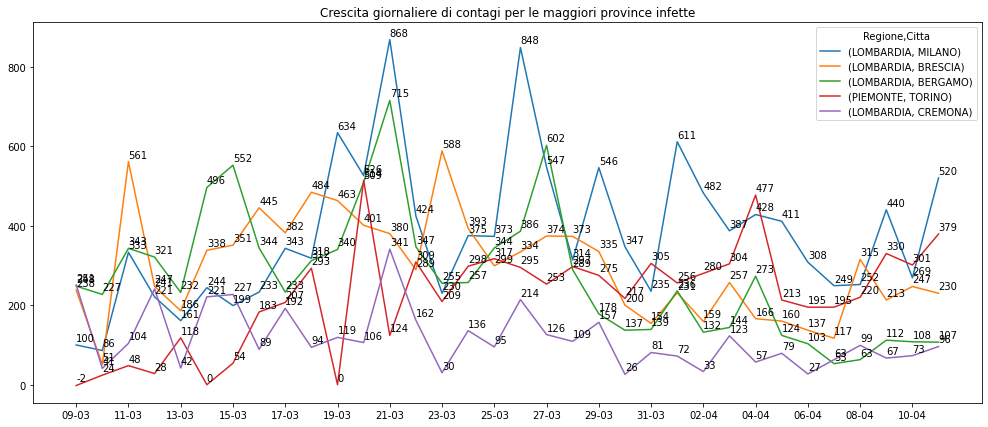

In [10]:
_ = plot_annotate(crescita.head(5), 'Crescita giornaliere di contagi per le maggiori province infette')

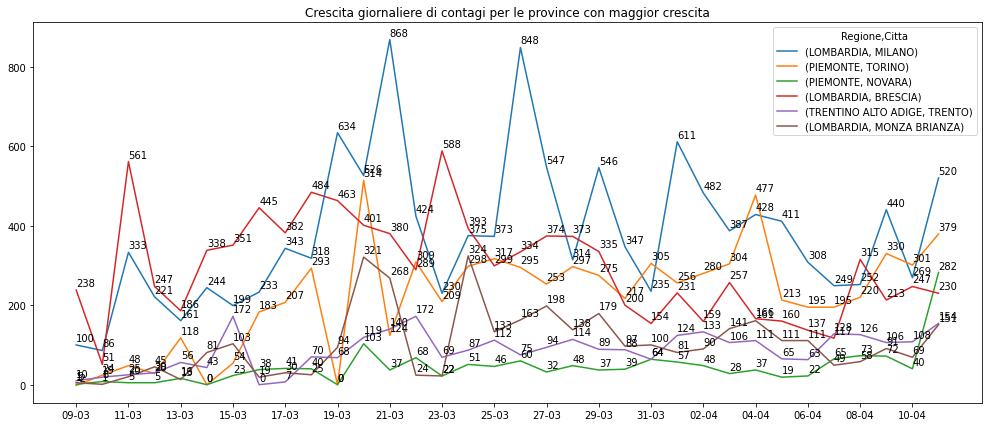

In [11]:
ax = plot_annotate(crescita.sort_values(by=crescita.columns[-1], ascending=False).head(6),
                   'Crescita giornaliere di contagi per le province con maggior crescita')
#_ = ax.set_ylim(-111,ax.get_ylim()[1])

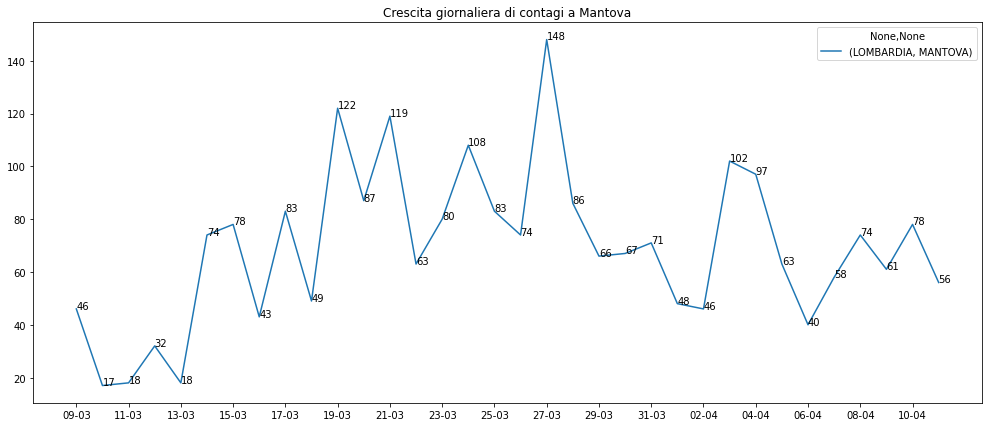

In [12]:
_ = plot_annotate(crescita.loc[('LOMBARDIA','MANTOVA')].to_frame().T, 'Crescita giornaliera di contagi a Mantova', ydelta=0)

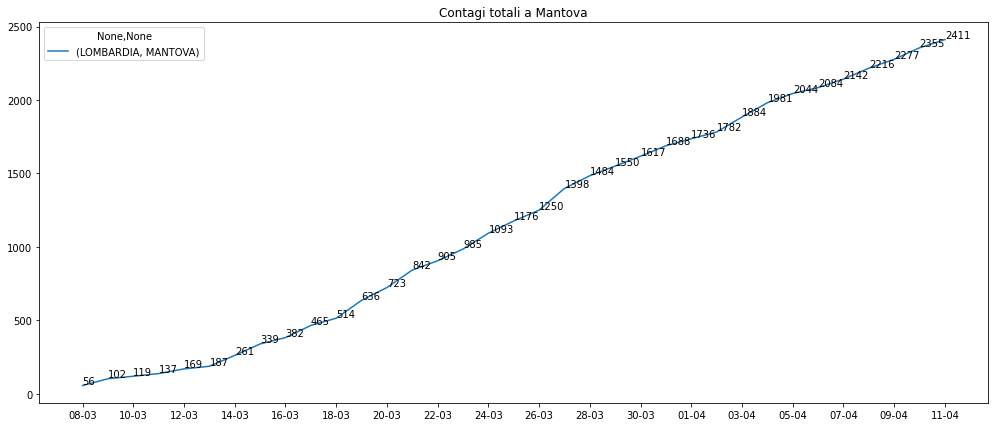

In [13]:
_ = plot_annotate(sorted_by_infections.loc[('LOMBARDIA','MANTOVA')].to_frame().T, 'Contagi totali a Mantova')

# Average 3 days

In [0]:
avg3 = pd.DataFrame(index=sorted_by_infections.index)
for meno2,ieri, oggi in zip(crescita.columns[:-2], crescita.columns[1:-1], crescita.columns[2:]):
  avg3[oggi] = pd.concat([crescita[oggi], crescita[ieri], crescita[meno2]], axis=1).mean(axis=1)

In [0]:
avg3 = avg3.astype('int32')

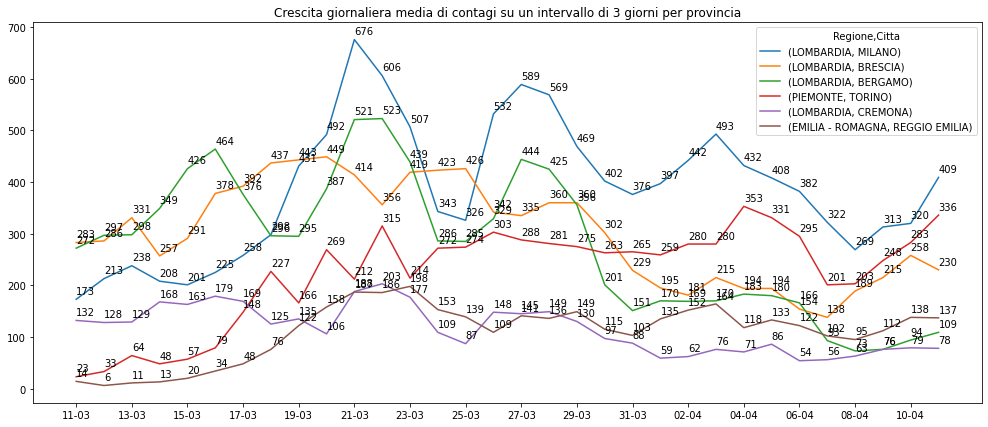

In [16]:
_ = plot_annotate(avg3.head(6), 'Crescita giornaliera media di contagi su un intervallo di 3 giorni per provincia')

In [0]:
casi_italia = sorted_by_infections.sum(axis=0).to_frame().T
casi_italia.index= ['Italia']

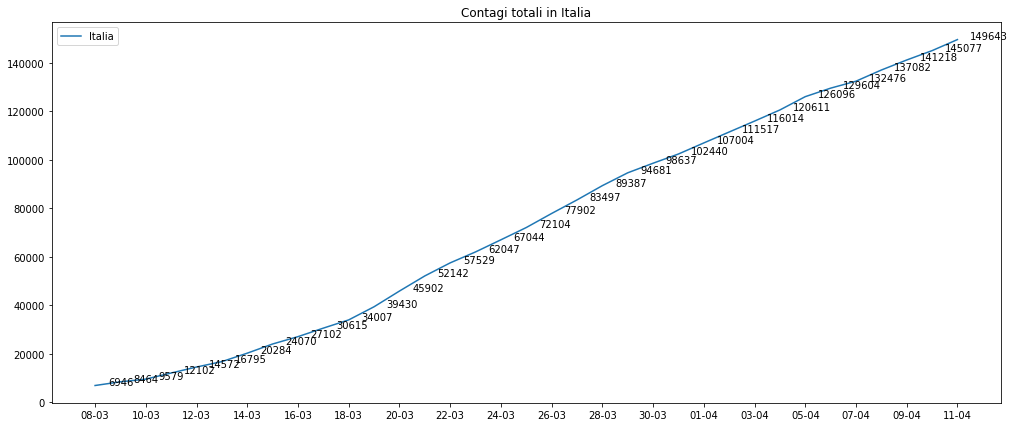

In [18]:
_ = plot_annotate(casi_italia, 'Contagi totali in Italia', xdelta=0.5)

In [0]:
crescita_italia = crescita.sum().to_frame().T
crescita_italia.index = ['Italia']

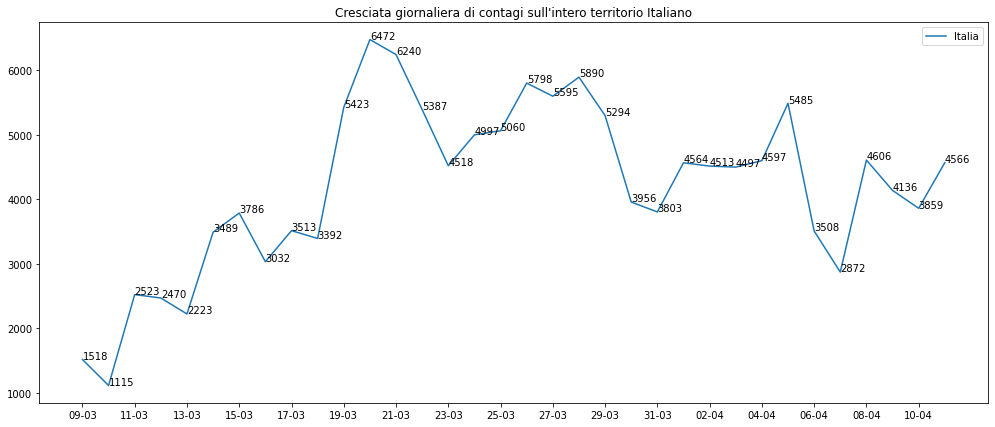

In [20]:
_ = plot_annotate(crescita_italia, 'Cresciata giornaliera di contagi sull\'intero territorio Italiano')

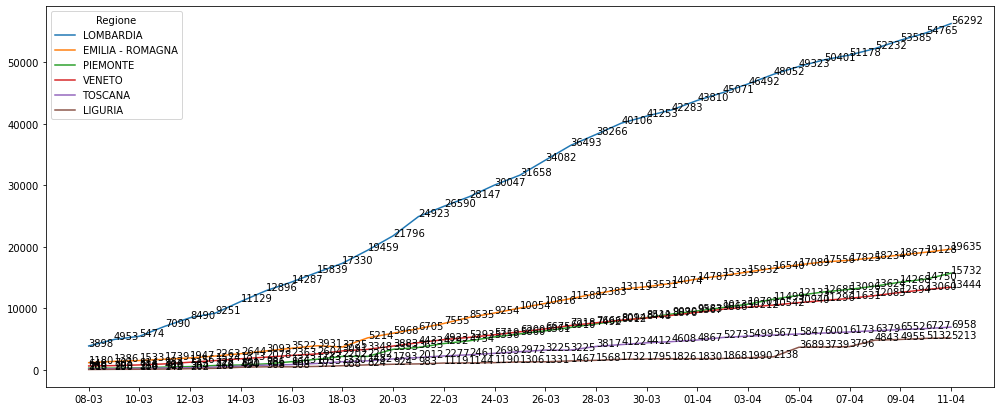

In [21]:
regioni = sorted_by_infections.groupby('Regione').sum()
regioni = regioni.sort_values(by=[regioni.columns[-1]],ascending=False)
_ = plot_annotate(regioni.head(6))

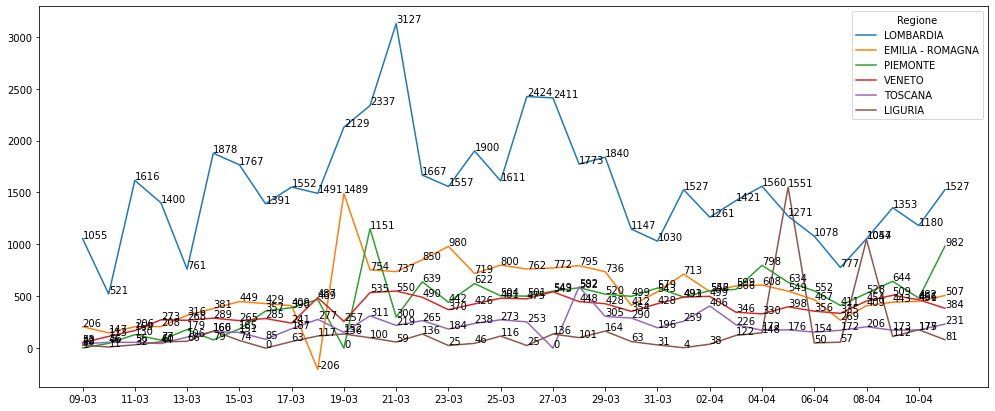

In [22]:
crescita_regioni = crescita.groupby('Regione').sum().loc[regioni.index]
_ = plot_annotate(crescita_regioni.head(6))
